<a href="https://colab.research.google.com/github/bcaffo/ds4bme_intro/blob/master/notebooks/notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuous prediction with regression

The last time we discussed a strict threshold classifier with accuracy as the loss function. Now consider continuous prediction, we need a loss function. A reasonable strategy would be to minimize the squared distances between our predictions and the observed values. In other words, 
$$
\sum_{i=1}^n (Y_i - \hat \mu_i)^2.
$$

If we were to dived this by $n$, it would be the average of the squared errors, or the *mean squared error* (MSE). We can use minimizing the squared error both as a rule for finding a good prediction and as our evaluation strategy for held out data.  

What's left is to figure out how to come up with $\hat \mu_i$, our predictions for the observation $Y_i$. 

Consider the previous lecture's example, consider trying to get the FLAIR value from the other, non-FLAIR, imaging values. For 





In [0]:
import numpy as np
from scipy import stats as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
## this sets some style parameters
sns.set()

## Download in the data if it's not already there
! if [ ! -e oasis.csv ]; \
then wget https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv; \
fi;

## Read in the data and display a few rows
dat = pd.read_csv("oasis.csv")
dat.head(4)

,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0


Let's look at the non-smoothed data (omitting the `_10` and `_20`) using a pair plot. I'm color coding by whether or not the specific voxel is a lesion.

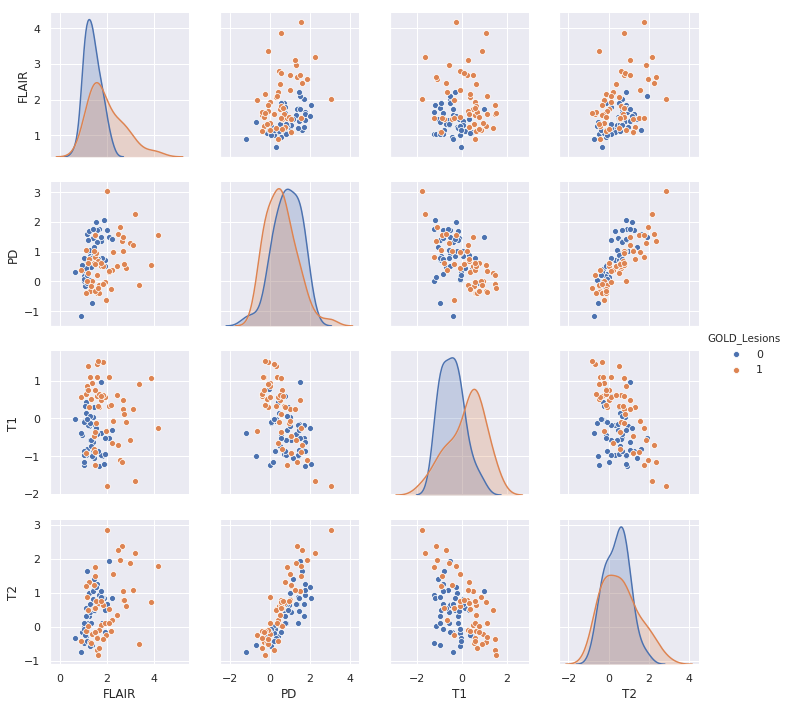

In [0]:
sns.pairplot(dat, vars = ['FLAIR', 'PD', 'T1', 'T2'], hue = 'GOLD_Lesions')

T2 and PD (proton density) look pretty linearly related. Imagine a study where a researcher collected T2 but did not collect PD. Let's try to predict their PD values from the T2 values using a line. We'll use least squares as the loss function. Specifically

$$
\sum_{v=1}^V (PD_v - \beta_0 - \beta_1 T2_v)^2
$$

where $v$ stands for voxel and $PD_v$ for the PD value at voxel $v$, $T2_v$ as the T2 value at voxel $v$ and $\beta_0$ and $\beta_1$ are parameters that we have to learn. 

A general equation for fitting a line to data is
$$
\sum_{i=1}^n (Y_i - \beta_0 - \beta_1 X_i)^2

$$
where we want to use $X_i$ to predict $Y_i$. 

It turns out that $\beta_0$ and $\beta_1$ have optimal solutions that we can write down. We get
$$
\hat \beta_1 = Cor(X, Y) \frac{SD_Y}{SD_X}
$$
where $Cor(X, Y)$ is the (Pearson) **correlation** between $X$ and $Y$ and $SD_X$ is the **standard deviation** of $X$ (and $SD_Y$ is for $Y$). The intercept satisfies
$$
\hat \beta_0 = \bar Y - \bar X \hat \beta_1
$$
where $\bar X$ and $\bar Y$ are the means. 

Notice this latter equation reorganized is just
$$
\bar Y = \hat \beta_0 + \bar X \hat \beta_1
$$
pointing out that the fitted line has to go through the point $(\bar X, \bar Y)$. 

## Some definitions
* The **covariance** is defined as 
$$Cov(X,Y) = \sum_{i=1}^n (Y_i - \bar Y) (X_i - \bar X) / (N-1)$$
* The **standard deviation** of $X$ is $SD_X$, 
$$
\sqrt{Cov(X, X)}
$$
* The Pearson **correlation** is defined as 
$$
\frac{Cov(X, Y)}{SD_X \times SD_Y}
$$


The Pearson correlation measures the degree of linear association between two variables where neither is thought of as an outcome or predictor. It is a unit free quantity. If you just say "correlation" without further context, it's understood to mean the Pearson correlation. The covariance measures the same thing, though it has the units of the units X times the units of Y. The sample standard deviation of X has the units of X and measures the spread, or variability, of X. The variance, $Cov(X, X)$, is simply the square of the standard deviation and has units of X squared.

[0.3575995777786273, 0.7501876813563654]


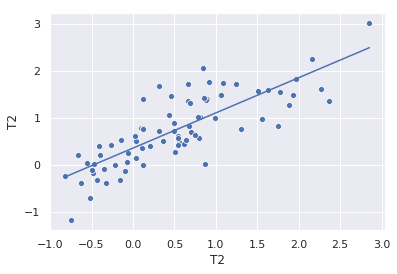

In [0]:
x = dat['T2']
y = dat['PD']
trainFraction = 0.75

## Hold out data
sample = np.random.uniform(size = 100) < trainFraction
xtrain = x[ sample]
ytrain = y[ sample]
xtest =  x[~sample]
ytest =  y[~sample]

## get the slope on the training data
beta1 = st.pearsonr(xtrain, ytrain)[0] * np.std(ytrain) / np.std(xtrain)
beta0 = np.mean(ytrain) - np.mean(xtrain) * beta1
print([beta0, beta1])

sns.scatterplot(xtrain, ytrain)
## add a line
sns.lineplot(xtrain, beta0 + beta1 * xtrain)


LinregressResult(slope=0.7501876813563655, intercept=0.3575995777786272, rvalue=0.8063396481545092, pvalue=5.206724152484508e-19, stderr=0.0631197373474049)


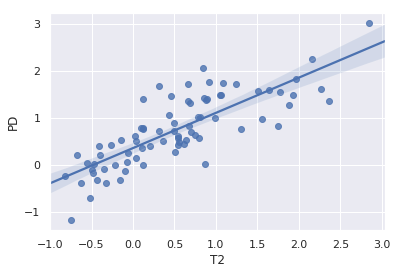

In [0]:
print(st.linregress(x = xtrain, y = ytrain))
sns.regplot(xtrain, ytrain)

Let's now calculate our predictions on the test set. Recall, the test set was not used to come up with estimates of $\beta_0$ and $\beta_1$. We'll show the training MSE and the testing MSE as well as a plot of the test set actual Ys versus the predicted ones.

[0.19740482076071508, 0.14423355311215716]


Text(0, 0.5, 'Actual PD value from ytest')

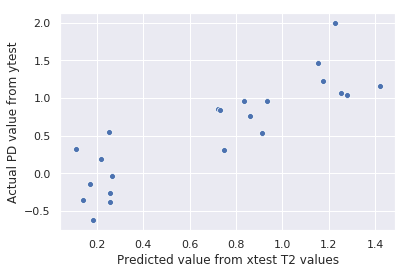

In [0]:
yhat_test = beta0 + beta1 * xtest
yhat_train = beta0 + beta1 * xtrain

## claculate the MSE in the training and test sets
print([ np.mean( (ytrain - yhat_train) ** 2), 
        np.mean( (ytest -  yhat_test) ** 2 ) ])


sns.scatterplot(yhat_test, ytest)
plt.xlabel('Predicted value from xtest T2 values')
plt.ylabel('Actual PD value from ytest')


